In [1]:
%matplotlib inline

[link text](https://)
Sequence-to-Sequence Modeling with nn.Transformer and TorchText
===============================================================

This is a tutorial on how to train a sequence-to-sequence model
that uses the
`nn.Transformer <https://pytorch.org/docs/master/nn.html?highlight=nn%20transformer#torch.nn.Transformer>`__ module.

PyTorch 1.2 release includes a standard transformer module based on the
paper `Attention is All You
Need <https://arxiv.org/pdf/1706.03762.pdf>`__. The transformer model
has been proved to be superior in quality for many sequence-to-sequence
problems while being more parallelizable. The ``nn.Transformer`` module
relies entirely on an attention mechanism (another module recently
implemented as `nn.MultiheadAttention <https://pytorch.org/docs/master/nn.html?highlight=multiheadattention#torch.nn.MultiheadAttention>`__) to draw global dependencies
between input and output. The ``nn.Transformer`` module is now highly
modularized such that a single component (like `nn.TransformerEncoder <https://pytorch.org/docs/master/nn.html?highlight=nn%20transformerencoder#torch.nn.TransformerEncoder>`__
in this tutorial) can be easily adapted/composed.

![](https://github.com/pytorch/tutorials/blob/gh-pages/_downloads/_static/img/transformer_architecture.jpg?raw=1)





In [2]:
import math
import numpy as np
import os
import time

import torch

**Handler: Colab vs. Local Jupyter**

In [3]:
IN_COLAB = 'google.colab' in str(get_ipython())

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    NOTEBOOK_OUTDIR = 'MyDrive' + os.sep + 'output'
    %cd '/content/drive'
    TESTMODE_IPYNB = False
else:
    NOTEBOOK_OUTDIR = 'output'
    TESTMODE_IPYNB = True

os.makedirs(NOTEBOOK_OUTDIR, exist_ok=True)
DATADIR = NOTEBOOK_OUTDIR + os.sep + '.data'

print('Running in colab:', IN_COLAB)
print('Notebook output dir:', NOTEBOOK_OUTDIR)

Running in colab: False
Notebook output dir: output


**Handler: Set Device (CUDA)**

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('torch.cuda.is_available():', torch.cuda.is_available())
print('Device:', device)

torch.cuda.is_available(): False
Device: cpu


Define the model
----------------




In this tutorial, we train ``nn.TransformerEncoder`` model on a
language modeling task. The language modeling task is to assign a
probability for the likelihood of a given word (or a sequence of words)
to follow a sequence of words. A sequence of tokens are passed to the embedding
layer first, followed by a positional encoding layer to account for the order
of the word (see the next paragraph for more details). The
``nn.TransformerEncoder`` consists of multiple layers of
`nn.TransformerEncoderLayer <https://pytorch.org/docs/master/nn.html?highlight=transformerencoderlayer#torch.nn.TransformerEncoderLayer>`__. Along with the input sequence, a square
attention mask is required because the self-attention layers in
``nn.TransformerEncoder`` are only allowed to attend the earlier positions in
the sequence. For the language modeling task, any tokens on the future
positions should be masked. To have the actual words, the output
of ``nn.TransformerEncoder`` model is sent to the final Linear
layer, which is followed by a log-Softmax function.




In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

``PositionalEncoding`` module injects some information about the
relative or absolute position of the tokens in the sequence. The
positional encodings have the same dimension as the embeddings so that
the two can be summed. Here, we use ``sine`` and ``cosine`` functions of
different frequencies.




In [6]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

Load and batch data
-------------------




This tutorial uses ``torchtext`` to generate Wikitext-2 dataset. The
vocab object is built based on the train dataset and is used to numericalize
tokens into tensors. Starting from sequential data, the ``batchify()``
function arranges the dataset into columns, trimming off any tokens remaining
after the data has been divided into batches of size ``batch_size``.
For instance, with the alphabet as the sequence (total length of 26)
and a batch size of 4, we would divide the alphabet into 4 sequences of
length 6:

\begin{align}\begin{bmatrix}
  \text{A} & \text{B} & \text{C} & \ldots & \text{X} & \text{Y} & \text{Z}
  \end{bmatrix}
  \Rightarrow
  \begin{bmatrix}
  \begin{bmatrix}\text{A} \\ \text{B} \\ \text{C} \\ \text{D} \\ \text{E} \\ \text{F}\end{bmatrix} &
  \begin{bmatrix}\text{G} \\ \text{H} \\ \text{I} \\ \text{J} \\ \text{K} \\ \text{L}\end{bmatrix} &
  \begin{bmatrix}\text{M} \\ \text{N} \\ \text{O} \\ \text{P} \\ \text{Q} \\ \text{R}\end{bmatrix} &
  \begin{bmatrix}\text{S} \\ \text{T} \\ \text{U} \\ \text{V} \\ \text{W} \\ \text{X}\end{bmatrix}
  \end{bmatrix}\end{align}

These columns are treated as independent by the model, which means that
the dependence of ``G`` and ``F`` can not be learned, but allows more
efficient batch processing.




In [7]:
import io
import torch
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.legacy.vocab import Vocab as RetiredVocab

train_iter = WikiText2(root=DATADIR, split='train')
tokenizer = get_tokenizer('basic_english')
counter = Counter()
for line in train_iter:
    counter.update(tokenizer(line))
vocab = RetiredVocab(counter)

def data_process(raw_text_iter):
  data = [torch.tensor([vocab[token] for token in tokenizer(item)],
                       dtype=torch.long) for item in raw_text_iter]
  return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

train_iter, val_iter, test_iter = WikiText2(root=DATADIR)
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

def batchify(data, bsz):
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

batch_size = 32
eval_batch_size = 32
train_data = batchify(train_data, batch_size)
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

**Code Testing block: shorten the size of the training data to make training loop quicker**

In [8]:
data_reduce = 0.05

if TESTMODE_IPYNB:
    print('TRUNCATING DATA (testmode_ipynb=True)\nShapes before:')
    print(train_data.shape)
    print(test_data.shape)
    print(val_data.shape)
    train_data = train_data[0:int(data_reduce * train_data.shape[0]), :]
    test_data = test_data[0:int(data_reduce * test_data.shape[0]), :]
    val_data = val_data[0:int(data_reduce * val_data.shape[0]), :]
    print('Shapes after:')
    print(train_data.shape)
    print(test_data.shape)
    print(val_data.shape)


TRUNCATING DATA (testmode_ipynb=True)
Shapes before:
torch.Size([64062, 32])
torch.Size([7558, 32])
torch.Size([6700, 32])
Shapes after:
torch.Size([3203, 32])
torch.Size([377, 32])
torch.Size([335, 32])


``get_batch()`` function generates the input and target sequence for
the transformer model. It subdivides the source data into chunks of
length ``bptt``. For the language modeling task, the model needs the
following words as ``Target``. For example, with a ``bptt`` value of 2,
we’d get the following two Variables for ``i`` = 0:

![](https://github.com/pytorch/tutorials/blob/gh-pages/_downloads/_static/img/transformer_input_target.png?raw=1)


It should be noted that the chunks are along dimension 0, consistent
with the ``S`` dimension in the Transformer model. The batch dimension
``N`` is along dimension 1.




In [9]:
bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

def get_batch_alt(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target_alt = source[i+1:i+1+seq_len]
    return data, target_alt

Initiate an instance
--------------------




The model is set up with the hyperparameter below. The vocab size is
equal to the length of the vocab object.




In [10]:
ntokens = len(vocab.stoi) # the size of vocabulary

# Model 'A'
"""
emsize = 200              # embedding dimension
nhid = 200                # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2               # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2                 # the number of heads in the multiheadattention models
dropout = 0.2             # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)
"""

# Model 'B'
emsize = 512              # embedding dimension
nhid = 2048               # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 12              # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 8                 # the number of heads in the multiheadattention models
dropout = 0.1             # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

Run the model
-------------




`CrossEntropyLoss <https://pytorch.org/docs/master/nn.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss>`__
is applied to track the loss and
`SGD <https://pytorch.org/docs/master/optim.html?highlight=sgd#torch.optim.SGD>`__
implements stochastic gradient descent method as the optimizer. The initial
learning rate is set to 5.0. `StepLR <https://pytorch.org/docs/master/optim.html?highlight=steplr#torch.optim.lr_scheduler.StepLR>`__ is
applied to adjust the learn rate through epochs. During the
training, we use
`nn.utils.clip_grad_norm\_ <https://pytorch.org/docs/master/nn.html?highlight=nn%20utils%20clip_grad_norm#torch.nn.utils.clip_grad_norm_>`__
function to scale all the gradient together to prevent exploding.




In [11]:
criterion = nn.CrossEntropyLoss()
lr = 5.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train():
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    
    batch_indices = np.arange(0, train_data.size(0) - 1, bptt)
    loss_per_batch = 0.0 * batch_indices  # record the training loss for each batch
    
    for batch, i in enumerate(batch_indices):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()
        if data.size(0) != bptt:
            src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        
        # TODO check if scaling is correct
        loss_per_batch[batch] = loss

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_last_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
    return loss_per_batch

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            if data.size(0) != bptt:
                src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
            output = eval_model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)

Loop over epochs. Save the model if the validation loss is the best
we've seen so far. Adjust the learning rate after each epoch.



In [12]:
epochs = 10  # The number of epochs
   
batch_per_epoch = len(train_data) // bptt
if (len(train_data) - 1) % bptt != 0:
    batch_per_epoch += 1

training_ppl_train_fine = np.zeros(epochs * batch_per_epoch)
training_ppl_val_coarse = np.zeros(epochs)

best_val_loss = float("inf")
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    loss_per_batch = train()
    
    # print validation loss info each epoch
    validation_loss = evaluate(model, val_data)
    validation_ppl = math.exp(validation_loss)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     validation_loss, validation_ppl))
    print('-' * 89)
    
    # store loss info
    training_ppl_val_coarse[epoch-1] = validation_ppl
    training_ppl_train_fine[(epoch-1) * batch_per_epoch: (epoch)*batch_per_epoch] = np.exp(loss_per_batch)
    
    # save best model so far
    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
        best_model = model
        torch.save(best_model.state_dict(), NOTEBOOK_OUTDIR + os.sep + 'bestval_model_weights.pth')
        torch.save(best_model, NOTEBOOK_OUTDIR + os.sep + 'bestval_model.pth')
    scheduler.step()

-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 90.18s | valid loss  7.32 | valid ppl  1504.47
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 87.60s | valid loss  6.78 | valid ppl   878.39
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 91.08s | valid loss  6.79 | valid ppl   892.44
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 89.66s | valid loss  6.61 | valid ppl   742.06
--------------------------------------------------------------------------

Evaluate the model with the test dataset
-------------------------------------

Apply the best model to check the result with the test dataset.



In [13]:
test_loss = evaluate(best_model, test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

| End of training | test loss  6.54 | test ppl   693.90


**Save Model**

In [15]:
# Approach 1: save model weights
# load as: 
#   model.load_state_dict(torch.load('model_weights.pth'))
#   model.eval()
torch.save(model.state_dict(), NOTEBOOK_OUTDIR + os.sep + 'end_model_weights.pth')

# Approach 2: save model (class) entirely (uses pickle)
# load as: 
#   model = torch.load('model.pth')
torch.save(model, NOTEBOOK_OUTDIR + os.sep + 'end_model.pth')

# Plot training timeseries

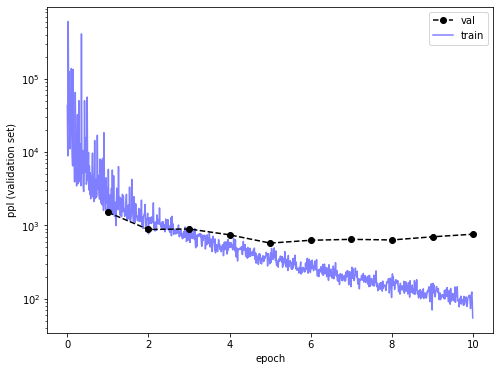

In [16]:
np.savetxt(NOTEBOOK_OUTDIR + os.sep + 'training_ppl_train_fine.txt', training_ppl_train_fine)
np.savetxt(NOTEBOOK_OUTDIR + os.sep + 'training_ppl_val_coarse.txt', training_ppl_val_coarse)

In [23]:
import matplotlib.pyplot as plt

epochs_axis = np.arange(1, epochs + 1)
epochs_axis_fine = np.linspace(0, epochs, epochs * batch_per_epoch + 1)[:-1]

def plot_training_timeseries(fname='training_performance', ext='.jpg', logy=True, xlims=None, ylims=None):

    plt.figure(figsize=(8,6))
    plt.plot(epochs_axis, training_ppl_val_coarse, '--ok', label='val', zorder=2)
    plt.plot(epochs_axis_fine, training_ppl_train_fine, 'b', label='train', zorder=1, alpha=0.5)
    plt.xlabel('epoch')
    plt.ylabel('ppl (validation set)')
    plt.legend()
    if logy:
        plt.yscale('log')
        fname += '_logy'
    if xlims is not None:
        plt.xlim(xlims[0], xlims[1])
    if ylims is not None:
        plt.ylim(ylims[0], ylims[1])
    plt.savefig(NOTEBOOK_OUTDIR + os.sep + fname + ext)
    plt.show()

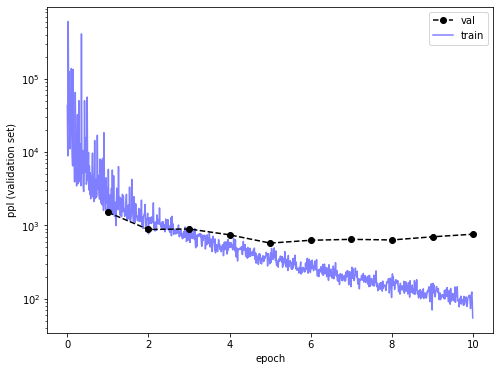

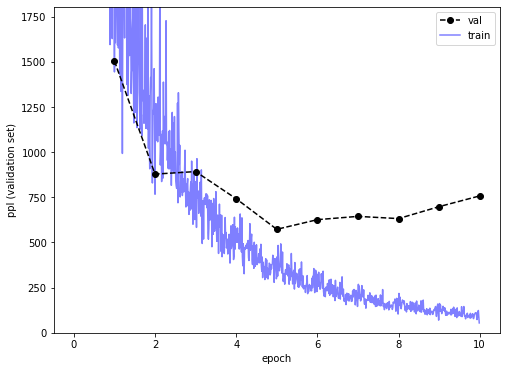

In [30]:
plot_training_timeseries(logy=True)
plot_training_timeseries(logy=False, ylims=(0, np.max(training_ppl_val_coarse) * 1.2))

In [29]:
print('Epoch after which validation loss is minimized (defines best_model):', np.argmin(training_ppl_val_coarse) + 1)

Epoch after which validation loss is minimized (defines best_model): 5
